# Анализ данных опроса студентов с использованием UMAP и кластеризации

## Методология CRISP-DM

Данный ноутбук следует методологии CRISP-DM (Cross-Industry Standard Process for Data Mining):

1. **Понимание бизнес-задачи** - определение целей и требований проекта
2. **Понимание данных** - сбор и изучение доступных данных
3. **Подготовка данных** - очистка и преобразование данных для анализа
4. **Моделирование** - применение методов машинного обучения (UMAP и кластеризация)
5. **Оценка результатов** - интерпретация и валидация полученных результатов
6. **Внедрение** - представление результатов и рекомендаций

В этом ноутбуке мы сосредоточимся на анализе данных из файла `dlia studentov.xlsx`.

## 1. Понимание бизнес-задачи

### Цель проекта

Целью данного проекта является анализ результатов опроса студентов о цифровых образовательных технологиях. Мы стремимся выявить скрытые паттерны и группы студентов с похожими ответами, используя методы снижения размерности (UMAP) и кластеризации.

### Задачи

1. Загрузить и изучить данные опроса студентов из файла `dlia studentov.xlsx`
2. Подготовить данные для анализа, включая переименование колонок и преобразование в бинарный формат
3. Применить UMAP для снижения размерности данных с учетом бинарной природы данных
4. Провести кластеризацию студентов на основе их ответов
5. Интерпретировать полученные кластеры и сделать выводы

### Бизнес-контекст

Понимание различных групп студентов и их отношения к цифровым образовательным технологиям может помочь образовательным учреждениям в разработке более эффективных стратегий обучения и улучшении образовательного процесса.

## 2. Понимание данных

### Импорт необходимых библиотек

In [1]:
%pip install seaborn
%pip install scikit-learn
%pip install umap-learn
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импорт основных библиотек для анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

# Импорт модулей для машинного обучения
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import umap

# Импорт собственных утилит
import sys
sys.path.append('../')
from column_utils import create_column_mapping, get_original_column_name, get_top_features_for_cluster, print_cluster_features
from data_utils import convert_to_binary, prepare_data_for_modeling, analyze_faculty_distribution
from umap_utils import optimize_umap_params_for_binary, plot_umap_embedding, find_optimal_clusters, plot_clusters, analyze_cluster_features, plot_cluster_heatmap, optimize_dbscan_for_binary

# Настройка отображения графиков
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

c:\Users\dmitr\Programs\anaconda3\envs\deep_learning_python3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка данных

In [3]:
# Загрузка данных из файла
file_path = 'data/dlia studentov.xlsx'
df_students = pd.read_excel(file_path)

# Вывод информации о размере датасета
print(f"Размер датасета: {df_students.shape}")

# Просмотр первых строк датасета
df_students.head()

Размер датасета: (711, 23)


ID       Время создания  \
0  1408291245  2023-06-07 20:41:17   
1  1405883214  2023-06-05 09:02:21   
2  1405869646  2023-06-05 08:44:38   
3  1405856131  2023-06-05 08:26:39   
4  1405854542  2023-06-05 08:24:47   

  На каком факультете/в каком институте Вы обучаетесь?  \
0                 институт истории и социальных наук     
1                                институт педагогики     
2                                институт педагогики     
3                                институт педагогики     
4                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                                             Moodle                                          
4                                             Moodle                                          

  Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)  \
0                                                нет                                                                             
1                                                 да                                                                             
2                                                 да                                                                             
3                                                 да                                                                             
4                                                 да                                                                             

  Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?  \
0                                                нет                                                                                           
1                                                 да                                                                                           
2                                                 да                                                                                           
3                                                 да                                                                                           
4                                                 да                                                                                           

  Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)  \
0                                                нет                                                  
1                                                нет                                                  
2                                                 да                                                  
3                                                нет                                                  
4                                                нет                                                  

  Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?  \
0                                                нет                                                                             
1                                                 да                                                                             
2                                                 да                                                                             
3                                                нет                         

### Исследование структуры данных

In [4]:
# Вывод информации о колонках
print("Список колонок:")
for i, col in enumerate(df_students.columns):
    print(f"{i}: {col}")

Список колонок:
0: ID
1: Время создания
2: На каком факультете/в каком институте Вы обучаетесь?
3: Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?
4: Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)
5: Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?
6: Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)
7: Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?
8: Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?
9: Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?
10: Были ли для каждого Практического задания разработа

In [5]:
# Проверка наличия пропущенных значений
missing_values = df_students.isnull().sum()
print("Количество пропущенных значений по колонкам:")
print(missing_values[missing_values > 0])

Количество пропущенных значений по колонкам:
Series([], dtype: int64)


Распределение студентов по факультетам/институтам:
На каком факультете/в каком институте Вы обучаетесь?
институт педагогики                                                  89
филологический факультет                                             88
институт дефектологического образования и реабилитации               61
институт иностранных языков                                          60
институт детства                                                     58
институт физической культуры и спорта                                41
факультет безопасности жизнедеятельности                             41
институт истории и социальных наук                                   40
факультет математики                                                 39
институт философии человека                                          36
юридический факультет                                                34
институт информационных технологий и технологического образования    32
институт музыки, театра и хореог

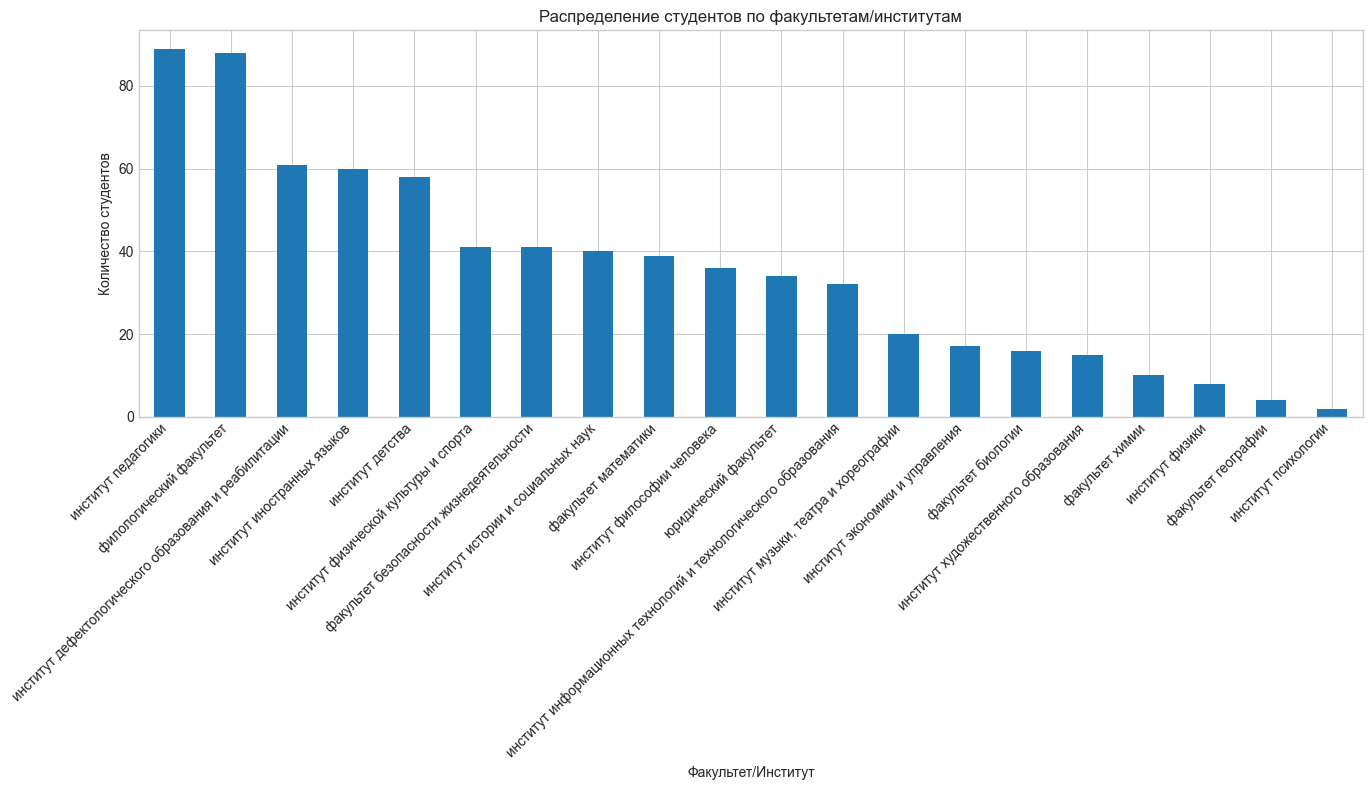

In [6]:
# Анализ распределения факультетов/институтов
if 'На каком факультете/в каком институте Вы обучаетесь?' in df_students.columns:
    faculty_counts = df_students['На каком факультете/в каком институте Вы обучаетесь?'].value_counts()
    print("Распределение студентов по факультетам/институтам:")
    print(faculty_counts)
    
    # Визуализация распределения
    plt.figure(figsize=(14, 8))
    faculty_counts.plot(kind='bar')
    plt.title('Распределение студентов по факультетам/институтам')
    plt.xlabel('Факультет/Институт')
    plt.ylabel('Количество студентов')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 3. Подготовка данных

### Переименование колонок для удобства работы

In [7]:
# Применение переименования колонок с использованием функции из utils
column_mapping = create_column_mapping(df_students)
df_renamed = df_students.rename(columns=column_mapping)

# Создание обратного словаря для интерпретации результатов
reverse_mapping = {v: k for k, v in column_mapping.items()}

# Сохранение словарей для дальнейшего использования
with open('column_mapping.pkl', 'wb') as f:
    pickle.dump(column_mapping, f)
with open('reverse_mapping.pkl', 'wb') as f:
    pickle.dump(reverse_mapping, f)

# Вывод первых строк переименованного датасета
df_renamed.head()

ID       Время создания                             faculty  \
0  1408291245  2023-06-07 20:41:17  институт истории и социальных наук   
1  1405883214  2023-06-05 09:02:21                 институт педагогики   
2  1405869646  2023-06-05 08:44:38                 институт педагогики   
3  1405856131  2023-06-05 08:26:39                 институт педагогики   
4  1405854542  2023-06-05 08:24:47                 институт педагогики   

      q_1  q_2  q_3  q_4  q_5  q_6  q_7  ... q_11 q_12 q_13 q_14 q_15 q_16  \
0  Moodle  нет  нет  нет  нет   да  нет  ...   да   да  нет   да  нет   да   
1  Moodle   да   да  нет   да  нет   да  ...   да   да   да   да   да   да   
2  Moodle   да   да   да   да   да   да  ...   да   да   да   да   да   да   
3  Moodle   да   да  нет  нет   да   да  ...   да   да   да   да   да   да   
4  Moodle   да   да  нет  нет   да   да  ...   да   да   да   да  нет  нет   

  q_17 q_18 q_19 q_20  
0  нет   да   да   да  
1   да   да   да   да  
2   да   да   да   да  
3   да   да   да   да  
4   да  нет  нет   да  

[5 rows x 23 columns]

### Преобразование данных в бинарный формат

In [8]:
# Применение преобразования в бинарный формат с использованием функции из utils
# Проверка корректности работы функции convert_to_binary
df_binary = convert_to_binary(df_renamed)

# Проверка, что все значения в бинарном датасете равны 0 или 1
if ((df_binary == 0) | (df_binary == 1)).all().all():
    print("Преобразование выполнено корректно: все значения бинарны (0 или 1).")
else:
    print("Ошибка: найдены значения, отличные от 0 и 1.")

# Вывод первых строк бинарного датасета для визуальной проверки
df_binary.head()

# Вывод первых строк бинарного датасета
df_binary.head()

Ошибка: найдены значения, отличные от 0 и 1.


ID       Время создания                             faculty  q_1  \
0  1408291245  2023-06-07 20:41:17  институт истории и социальных наук    1   
1  1405883214  2023-06-05 09:02:21                 институт педагогики    1   
2  1405869646  2023-06-05 08:44:38                 институт педагогики    1   
3  1405856131  2023-06-05 08:26:39                 институт педагогики    1   
4  1405854542  2023-06-05 08:24:47                 институт педагогики    1   

   q_2  q_3  q_4  q_5  q_6  q_7  ...  q_11  q_12  q_13  q_14  q_15  q_16  \
0    0    0    0    0    1    0  ...     1     1     0     1     0     1   
1    1    1    0    1    0    1  ...     1     1     1     1     1     1   
2    1    1    1    1    1    1  ...     1     1     1     1     1     1   
3    1    1    0    0    1    1  ...     1     1     1     1     1     1   
4    1    1    0    0    1    1  ...     1     1     1     1     0     0   

   q_17  q_18  q_19  q_20  
0     0     1     1     1  
1     1     1     1     1  
2     1     1     1     1  
3     1     1     1     1  
4     1     0     0     1  

[5 rows x 23 columns]

### Подготовка данных для моделирования

In [9]:
# Подготовка данных для моделирования с использованием функции из utils
X, faculty_data, feature_columns = prepare_data_for_modeling(df_binary)

print(f"Размерность матрицы признаков: {X.shape}")
print(f"Количество признаков: {len(feature_columns)}")

Размерность матрицы признаков: (711, 20)
Количество признаков: 20


## 4. Моделирование

### 4.1 Снижение размерности с помощью UMAP

UMAP (Uniform Manifold Approximation and Projection) - это алгоритм снижения размерности, который хорошо сохраняет как локальную, так и глобальную структуру данных. Он особенно эффективен для визуализации высокоразмерных данных.

Для бинарных данных рекомендуется использовать метрику Жаккара (Jaccard), которая учитывает специфику бинарных признаков.

In [10]:
# Подбор оптимальных параметров UMAP для бинарных данных
umap_results = optimize_umap_params_for_binary(
    X, 
    n_neighbors_range=[5, 10, 15, 30, 50], 
    min_dist_range=[0.0, 0.1, 0.25, 0.5, 0.8],
    metric='jaccard',
    random_state=42
)

# Вывод лучших параметров
best_params = umap_results[0]
print(f"\nЛучшие параметры UMAP:")
print(f"n_neighbors={best_params['n_neighbors']}, min_dist={best_params['min_dist']}, "
      f"metric={best_params['metric']}, silhouette_score={best_params['silhouette_score']:.4f}")

n_neighbors=5, min_dist=0.0, metric=jaccard, silhouette_score=0.7186
n_neighbors=5, min_dist=0.1, metric=jaccard, silhouette_score=0.6742
n_neighbors=5, min_dist=0.25, metric=jaccard, silhouette_score=0.6487
n_neighbors=5, min_dist=0.5, metric=jaccard, silhouette_score=0.5779
n_neighbors=5, min_dist=0.8, metric=jaccard, silhouette_score=0.5681
n_neighbors=10, min_dist=0.0, metric=jaccard, silhouette_score=0.9179
n_neighbors=10, min_dist=0.1, metric=jaccard, silhouette_score=0.8668
n_neighbors=10, min_dist=0.25, metric=jaccard, silhouette_score=0.8847
n_neighbors=10, min_dist=0.5, metric=jaccard, silhouette_score=0.7838
n_neighbors=10, min_dist=0.8, metric=jaccard, silhouette_score=0.8122
n_neighbors=15, min_dist=0.0, metric=jaccard, silhouette_score=0.9183
n_neighbors=15, min_dist=0.1, metric=jaccard, silhouette_score=0.9208
n_neighbors=15, min_dist=0.25, metric=jaccard, silhouette_score=0.9570
n_neighbors=15, min_dist=0.5, metric=jaccard, silhouette_score=0.9342
n_neighbors=15, min_di

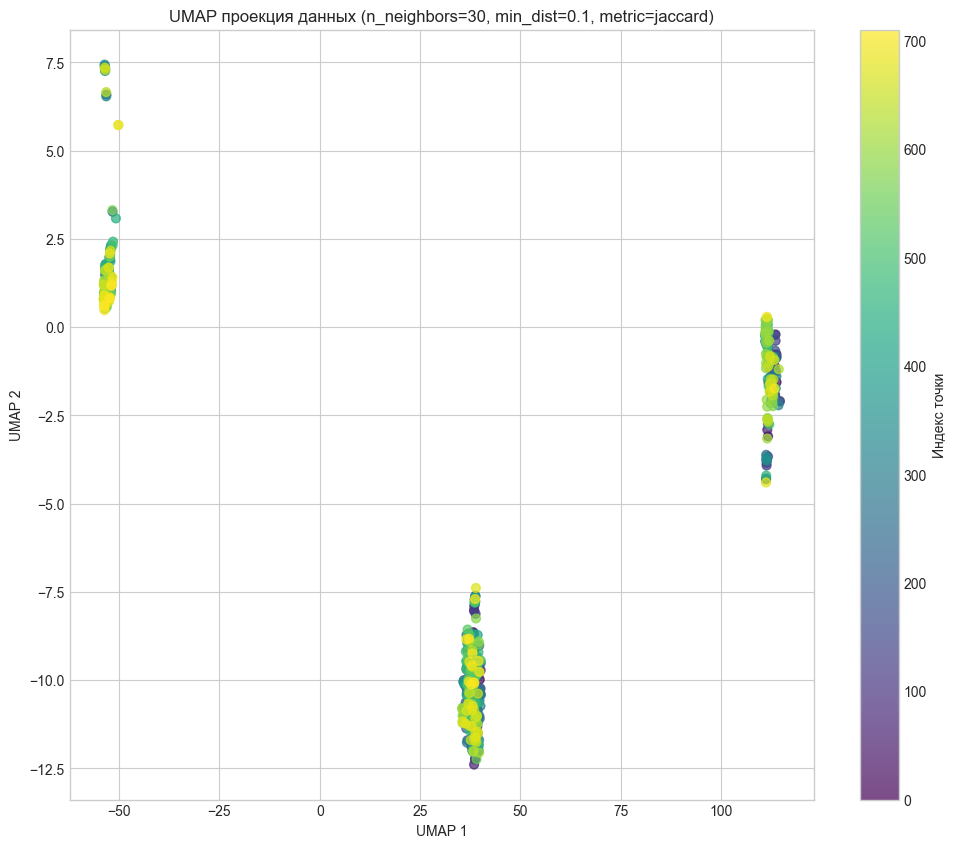

In [11]:
# Получение оптимальных параметров и эмбеддинга
best_n_neighbors = best_params['n_neighbors']
best_min_dist = best_params['min_dist']
best_metric = best_params['metric']
embedding = best_params['embedding']

# Визуализация результатов UMAP
plot_umap_embedding(
    embedding, 
    title=f'UMAP проекция данных (n_neighbors={best_n_neighbors}, min_dist={best_min_dist}, metric={best_metric})',
    figsize=(12, 10),
    point_size=40,
    alpha=0.7
)

### 4.2 Кластеризация с помощью K-Means

Теперь применим алгоритм K-Means для кластеризации данных в пространстве UMAP. Сначала определим оптимальное количество кластеров с помощью метода локтя и силуэтного анализа.

k=2, inertia=705377.00, silhouette_score=0.7639
k=3, inertia=1669.09, silhouette_score=0.9773
k=4, inertia=1247.74, silhouette_score=0.9395
k=5, inertia=944.40, silhouette_score=0.6652
k=6, inertia=766.52, silhouette_score=0.5233
k=7, inertia=594.85, silhouette_score=0.5309
k=8, inertia=511.83, silhouette_score=0.5434
k=9, inertia=435.47, silhouette_score=0.5421
k=10, inertia=379.80, silhouette_score=0.5567


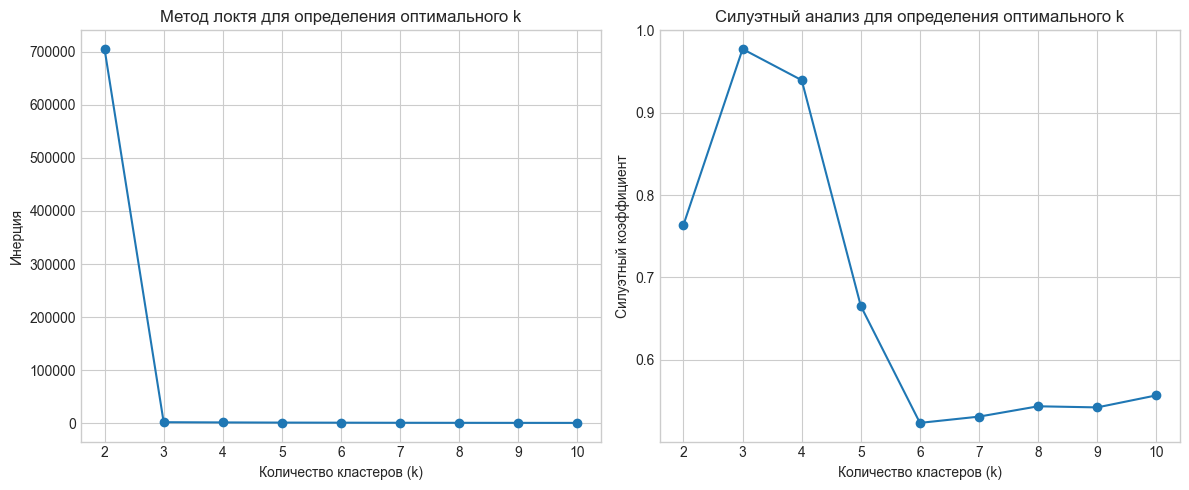

In [12]:
# Поиск оптимального количества кластеров
optimal_k, best_silhouette = find_optimal_clusters(embedding, max_k=10, random_state=42)

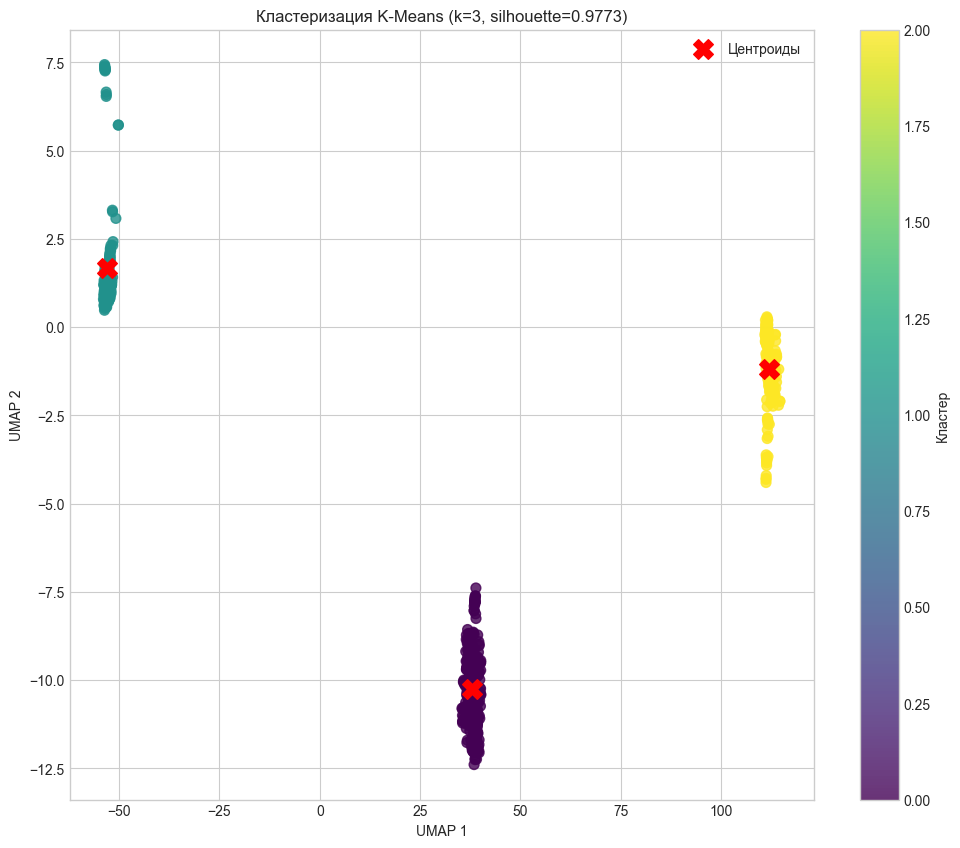

In [13]:
# Применение K-Means с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embedding)

# Визуализация результатов кластеризации
plot_clusters(
    embedding, 
    cluster_labels, 
    centroids=kmeans.cluster_centers_,
    figsize=(12, 10),
    title=f'Кластеризация K-Means (k={optimal_k}, silhouette={best_silhouette:.4f})'
)

### 4.3 Альтернативный метод кластеризации - DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) - это алгоритм кластеризации, основанный на плотности. Он может находить кластеры произвольной формы и автоматически определять количество кластеров.

In [14]:
# Подбор оптимальных параметров для DBSCAN
dbscan_results = optimize_dbscan_for_binary(
    embedding, 
    eps_range=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
    min_samples_range=[3, 5, 10, 15, 20],
    metric='euclidean'
)

# Вывод лучших параметров, если они найдены
if dbscan_results:
    best_dbscan = dbscan_results[0]
    print(f"\nЛучшие параметры DBSCAN:")
    print(f"eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}, "
          f"metric={best_dbscan['metric']}, n_clusters={best_dbscan['n_clusters']}, "
          f"silhouette_score={best_dbscan['silhouette_score']:.4f}, "
          f"noise={best_dbscan['noise_percentage']:.2f}%")

eps=0.1, min_samples=3, metric=euclidean, n_clusters=61, silhouette_score=0.5665, noise=41.21%
eps=0.1, min_samples=5, metric=euclidean, n_clusters=18, silhouette_score=0.7076, noise=68.78%
eps=0.1, min_samples=10, metric=euclidean, n_clusters=3, silhouette_score=0.9684, noise=92.97%
eps=0.2, min_samples=3, metric=euclidean, n_clusters=45, silhouette_score=0.4524, noise=10.83%
eps=0.2, min_samples=5, metric=euclidean, n_clusters=26, silhouette_score=0.4958, noise=26.58%
eps=0.2, min_samples=10, metric=euclidean, n_clusters=11, silhouette_score=0.6325, noise=58.51%
eps=0.2, min_samples=15, metric=euclidean, n_clusters=4, silhouette_score=0.7849, noise=75.39%
eps=0.2, min_samples=20, metric=euclidean, n_clusters=3, silhouette_score=0.9075, noise=81.86%
eps=0.3, min_samples=3, metric=euclidean, n_clusters=17, silhouette_score=0.2709, noise=2.95%
eps=0.3, min_samples=5, metric=euclidean, n_clusters=19, silhouette_score=0.3572, noise=7.31%
eps=0.3, min_samples=10, metric=euclidean, n_cluste

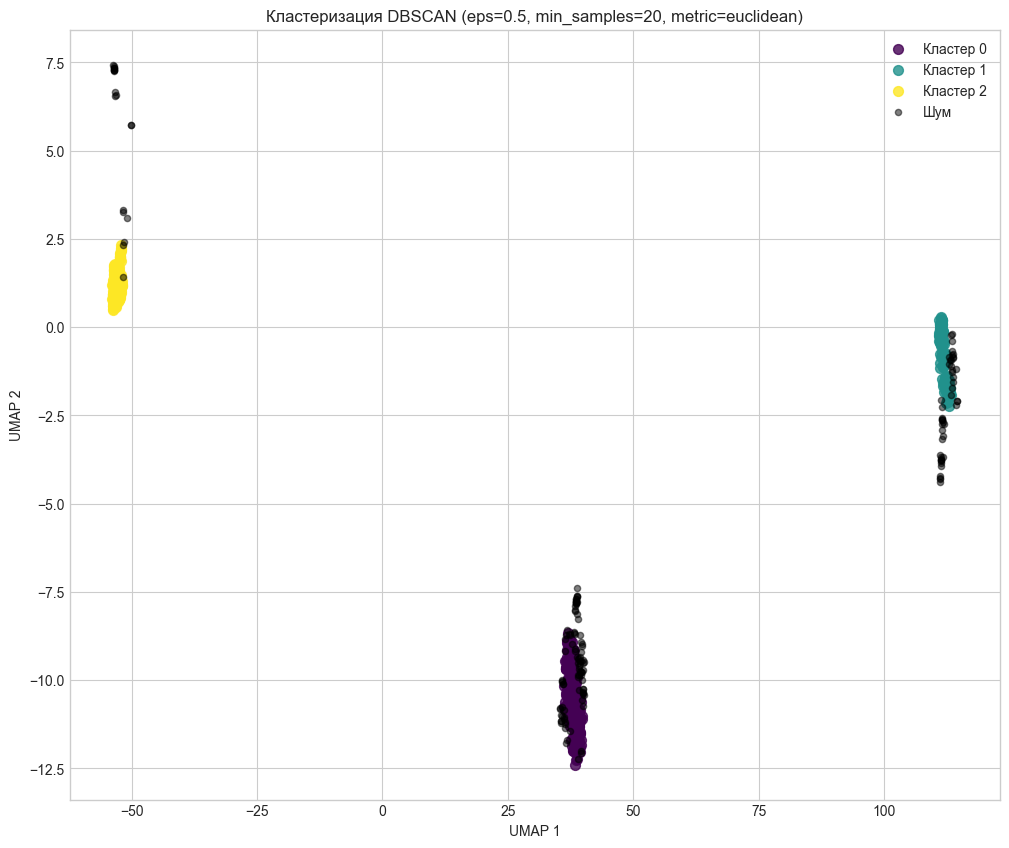

In [15]:
# Визуализация результатов DBSCAN, если параметры найдены
if dbscan_results:
    best_dbscan = dbscan_results[0]
    dbscan_labels = best_dbscan['labels']
    
    # Создание цветовой карты с черным цветом для шума (-1)
    unique_labels = set(dbscan_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels) - (1 if -1 in unique_labels else 0)))
    color_dict = {label: colors[i] for i, label in enumerate(sorted(list(unique_labels - {-1})))}
    if -1 in unique_labels:
        color_dict[-1] = [0, 0, 0, 1]  # Черный цвет для шума
    
    plt.figure(figsize=(12, 10))
    for label, color in color_dict.items():
        mask = dbscan_labels == label
        plt.scatter(embedding[mask, 0], embedding[mask, 1], 
                   color=color, 
                   label=f'Кластер {label}' if label != -1 else 'Шум',
                   s=50 if label != -1 else 20,
                   alpha=0.8 if label != -1 else 0.5)
    
    plt.title(f'Кластеризация DBSCAN (eps={best_dbscan["eps"]}, min_samples={best_dbscan["min_samples"]}, metric={best_dbscan["metric"]})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.grid(True)
    plt.show()

## 5. Оценка результатов

### 5.1 Анализ кластеров K-Means

Размеры кластеров:
cluster
0    329
1    176
2    206
Name: count, dtype: int64


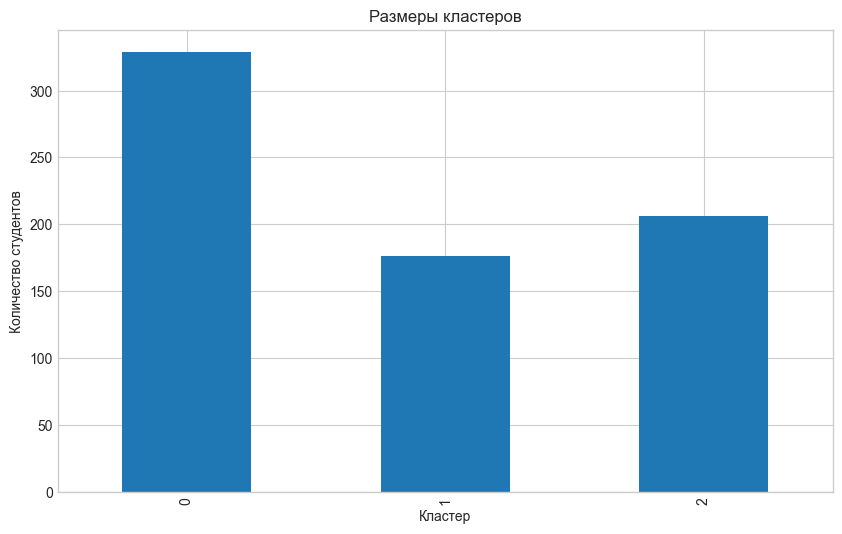

In [16]:
# Добавление меток кластеров в исходный датафрейм
df_with_clusters = df_binary.copy()
df_with_clusters['cluster'] = cluster_labels

# Анализ размеров кластеров
cluster_sizes = df_with_clusters['cluster'].value_counts().sort_index()
print("Размеры кластеров:")
print(cluster_sizes)

# Визуализация размеров кластеров
plt.figure(figsize=(10, 6))
cluster_sizes.plot(kind='bar')
plt.title('Размеры кластеров')
plt.xlabel('Кластер')
plt.ylabel('Количество студентов')
plt.grid(True, axis='y')
plt.show()

Средние значения признаков для каждого кластера:
              q_1       q_2       q_3       q_4       q_5       q_6       q_7  \
cluster                                                                         
0        0.975684  0.759878  0.920973  0.294833  0.300912  0.863222  0.848024   
1        0.017045  0.943182  0.954545  0.994318  0.789773  0.977273  0.931818   
2        0.975728  0.917476  0.927184  0.504854  0.577670  0.941748  0.888350   

              q_8       q_9      q_10      q_11      q_12      q_13      q_14  \
cluster                                                                         
0        0.598784  0.851064  0.729483  0.902736  0.902736  0.732523  0.835866   
1        0.982955  0.988636  0.818182  0.931818  0.988636  0.880682  0.971591   
2        0.883495  0.917476  0.873786  0.927184  0.951456  0.864078  0.907767   

             q_15      q_16      q_17      q_18      q_19      q_20  
cluster                                                              

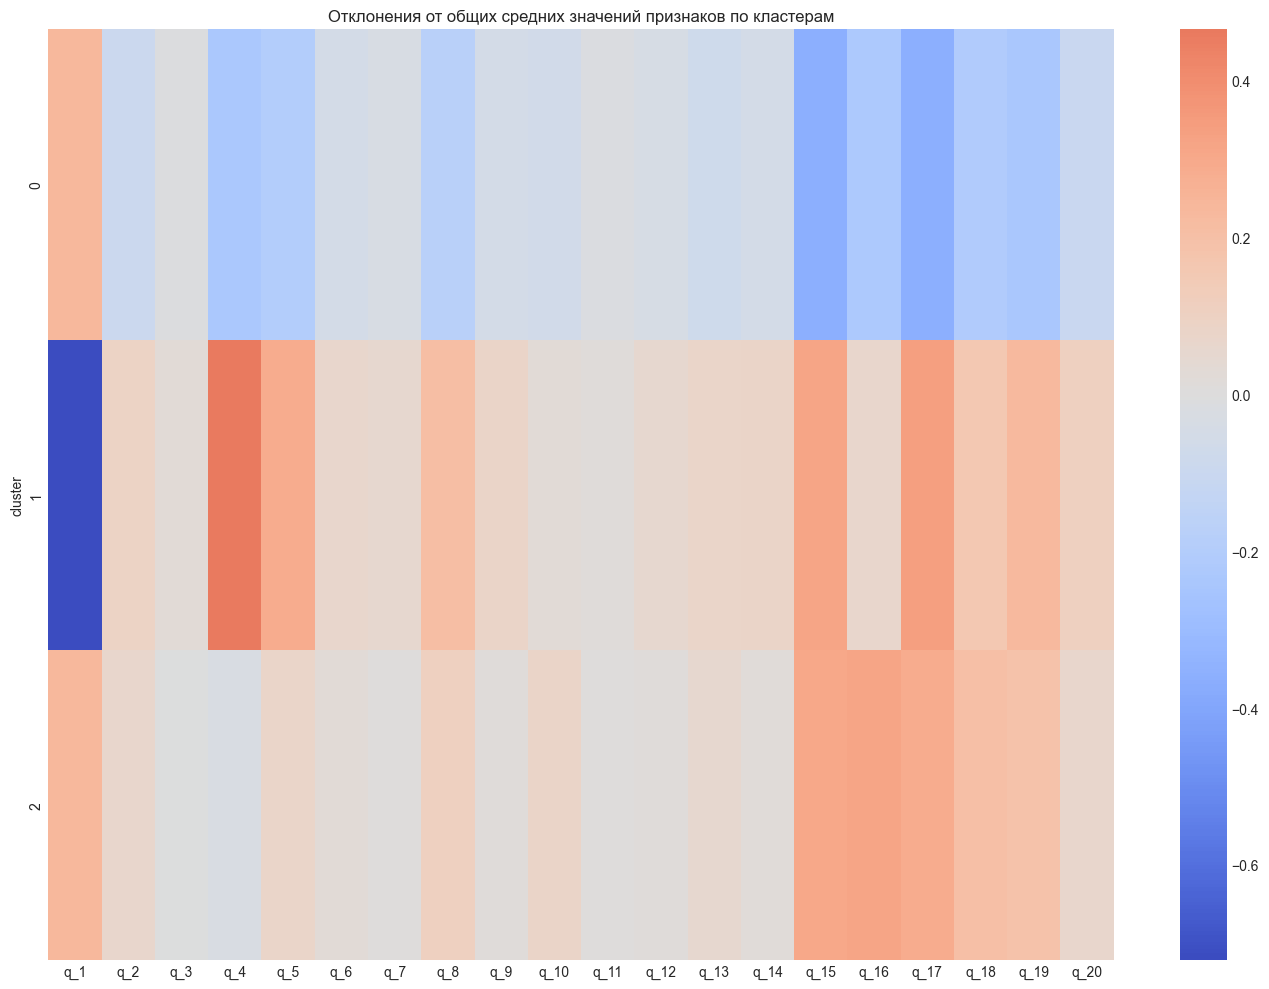

In [17]:
# Анализ характеристик кластеров
cluster_means, cluster_deviations = analyze_cluster_features(df_with_clusters, feature_columns)

# Вывод средних значений признаков для каждого кластера
print("Средние значения признаков для каждого кластера:")
print(cluster_means.head())

# Визуализация отклонений от общих средних
plot_cluster_heatmap(cluster_deviations, figsize=(14, 10))

In [18]:
# Определение наиболее важных признаков для каждого кластера
for cluster in cluster_deviations.index:
    print(f"\n{'='*80}\nКластер {cluster}:\n{'='*80}")
    
    # Получение топ-10 признаков для текущего кластера
    top_features = get_top_features_for_cluster(cluster_deviations, cluster, reverse_mapping, n=10)
    
    # Вывод результатов
    print("Признаки с положительным отклонением (выше среднего):")
    for feature, value, original_name in top_features['positive']:
        print(f"  {feature}: {value:.4f} - {original_name[:100]}..." 
              if len(original_name) > 100 else f"  {feature}: {value:.4f} - {original_name}")
    
    print("\nПризнаки с отрицательным отклонением (ниже среднего):")
    for feature, value, original_name in top_features['negative']:
        print(f"  {feature}: {value:.4f} - {original_name[:100]}..." 
              if len(original_name) > 100 else f"  {feature}: {value:.4f} - {original_name}")


Кластер 0:
Признаки с положительным отклонением (выше среднего):
  q_1: 0.2373 - Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?

Признаки с отрицательным отклонением (ниже среднего):
  q_17: -0.3608 - Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?
  q_15: -0.3599 - Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?
  q_19: -0.2399 - Было ли организовано взаимодействие с преподавателями посредством мессенджеров?
  q_4: -0.2340 - Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)
  q_16: -0.2297 - Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?
  q_18: -0.2119 - Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?
  q_5: -0.2012 - Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-код...
  q_8: -0.1776 - Были ли для каждого Практическог

### 5.2 Анализ распределения факультетов по кластерам

Проверим, как распределены студенты разных факультетов по кластерам. Это поможет понять, насколько кластеризация связана с принадлежностью к определенному факультету.

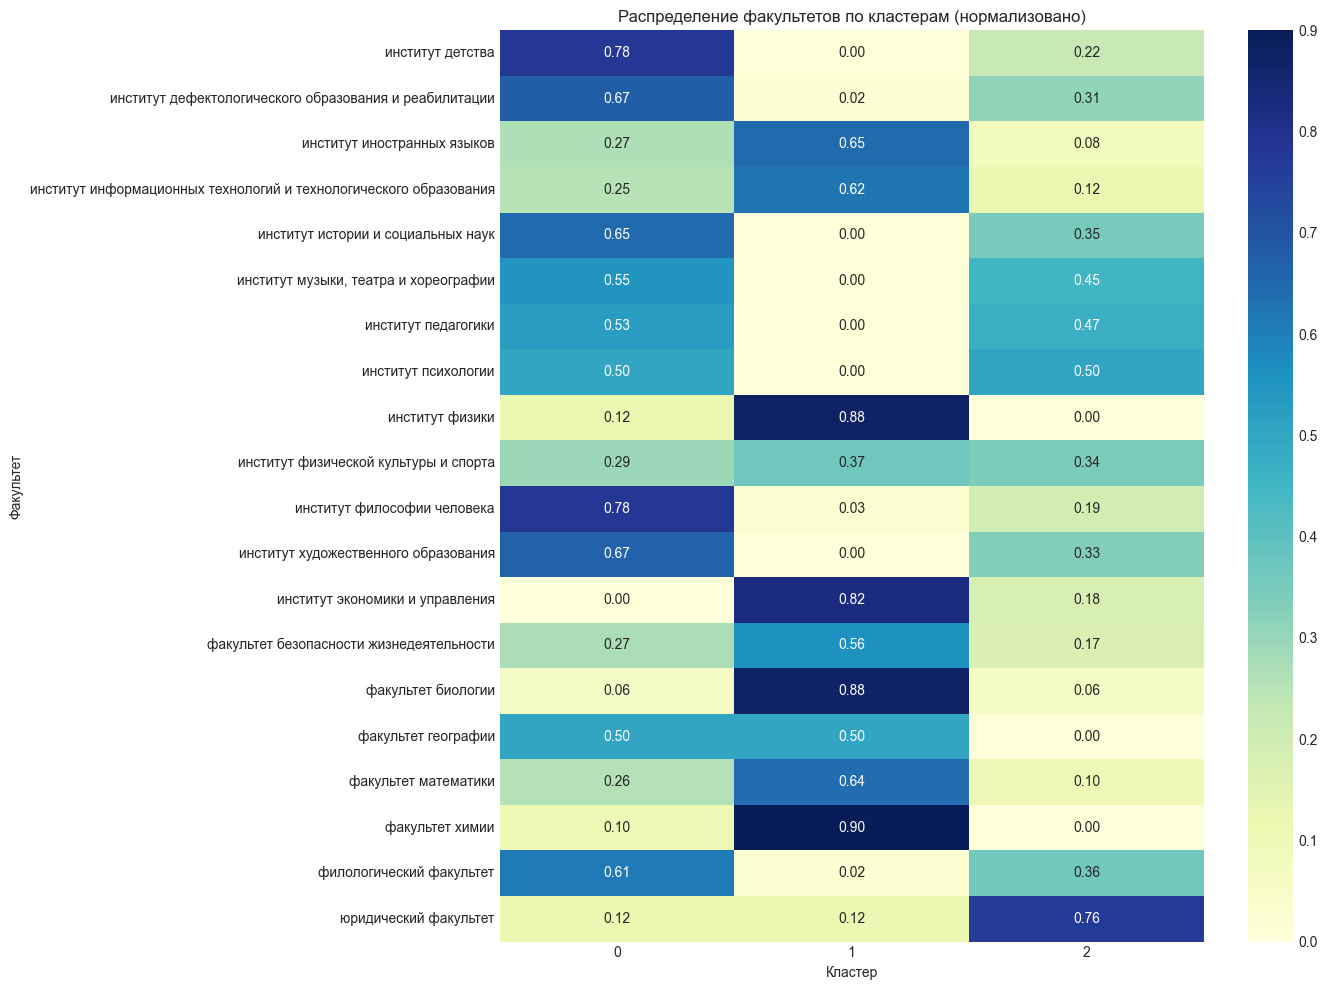

Абсолютное количество студентов каждого факультета в каждом кластере:
cluster                                              0   1   2
faculty                                                       
институт детства                                    45   0  13
институт дефектологического образования и реаби...  41   1  19
институт иностранных языков                         16  39   5
институт информационных технологий и технологич...   8  20   4
институт истории и социальных наук                  26   0  14
институт музыки, театра и хореографии               11   0   9
институт педагогики                                 47   0  42
институт психологии                                  1   0   1
институт физики                                      1   7   0
институт физической культуры и спорта               12  15  14
институт философии человека                         28   1   7
институт художественного образования                10   0   5
институт экономики и управления                 

In [19]:
# Анализ распределения факультетов по кластерам (если данные о факультетах доступны)
if 'faculty' in df_with_clusters.columns:
    # Получение кросс-таблиц с использованием функции из utils
    faculty_cluster_cross, faculty_cluster_norm = analyze_faculty_distribution(df_with_clusters)
    
    # Визуализация распределения
    plt.figure(figsize=(14, 10))
    sns.heatmap(faculty_cluster_norm, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.title('Распределение факультетов по кластерам (нормализовано)')
    plt.ylabel('Факультет')
    plt.xlabel('Кластер')
    plt.tight_layout()
    plt.show()
    
    # Вывод абсолютных значений
    print("Абсолютное количество студентов каждого факультета в каждом кластере:")
    print(faculty_cluster_cross)

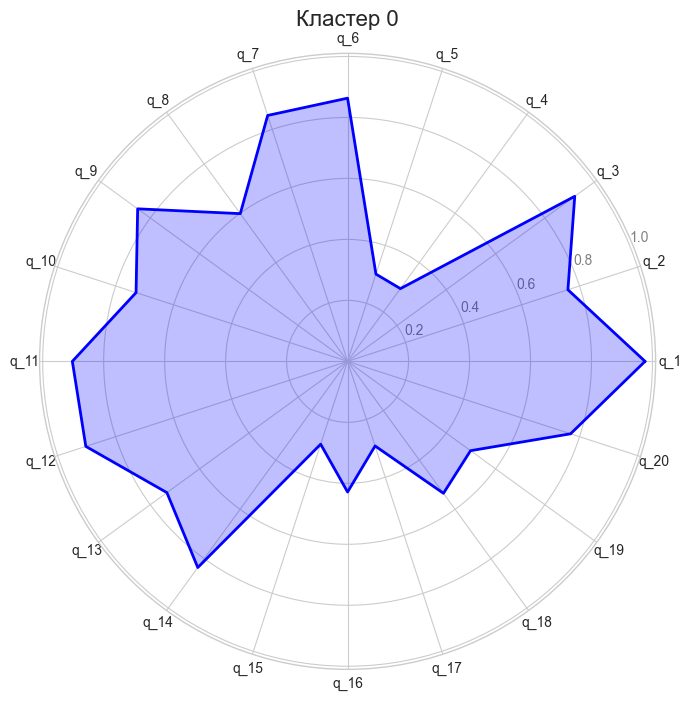

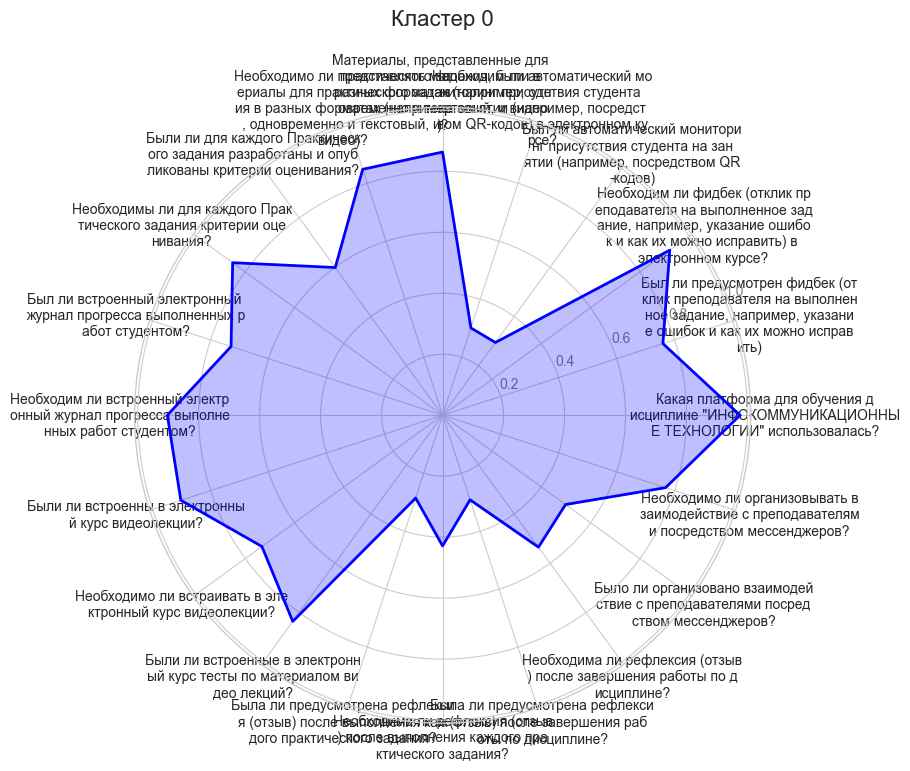

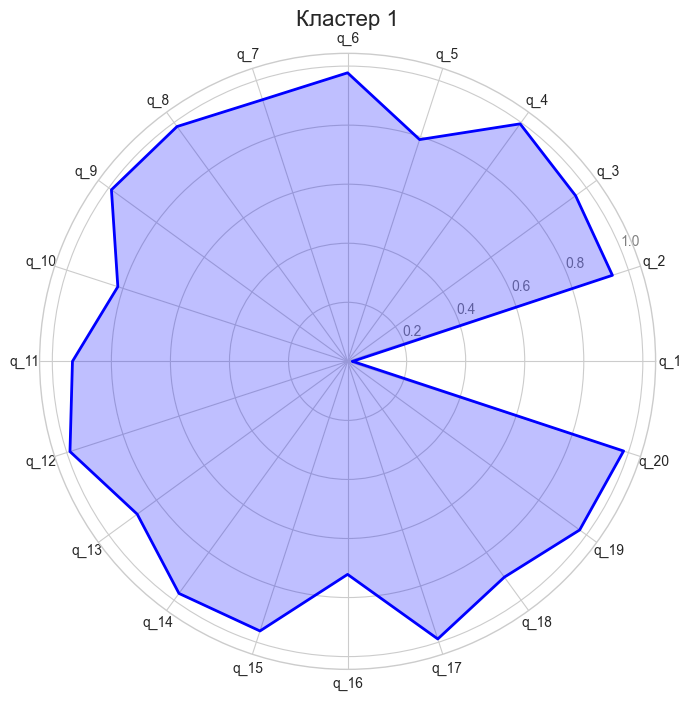

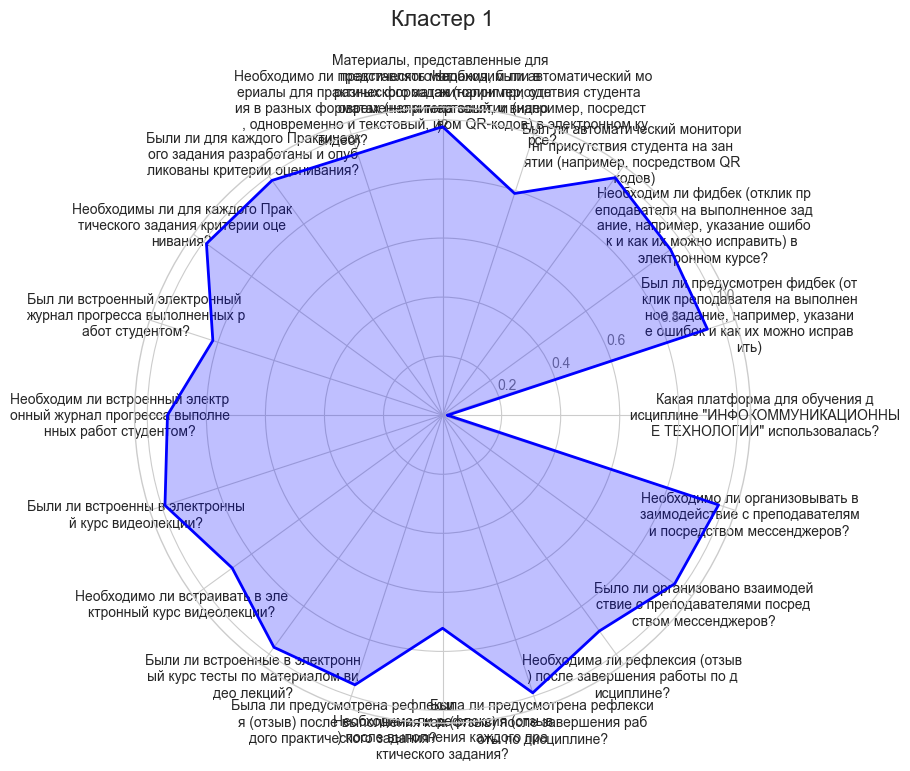

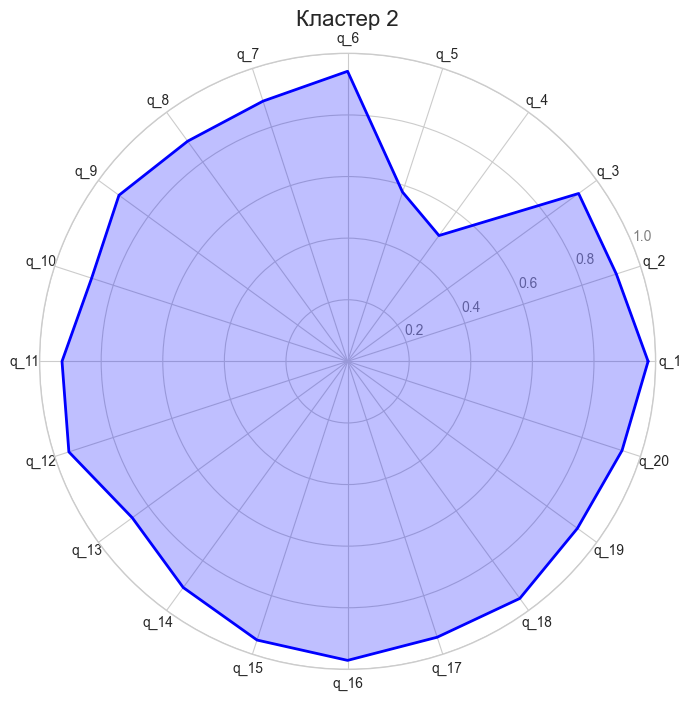

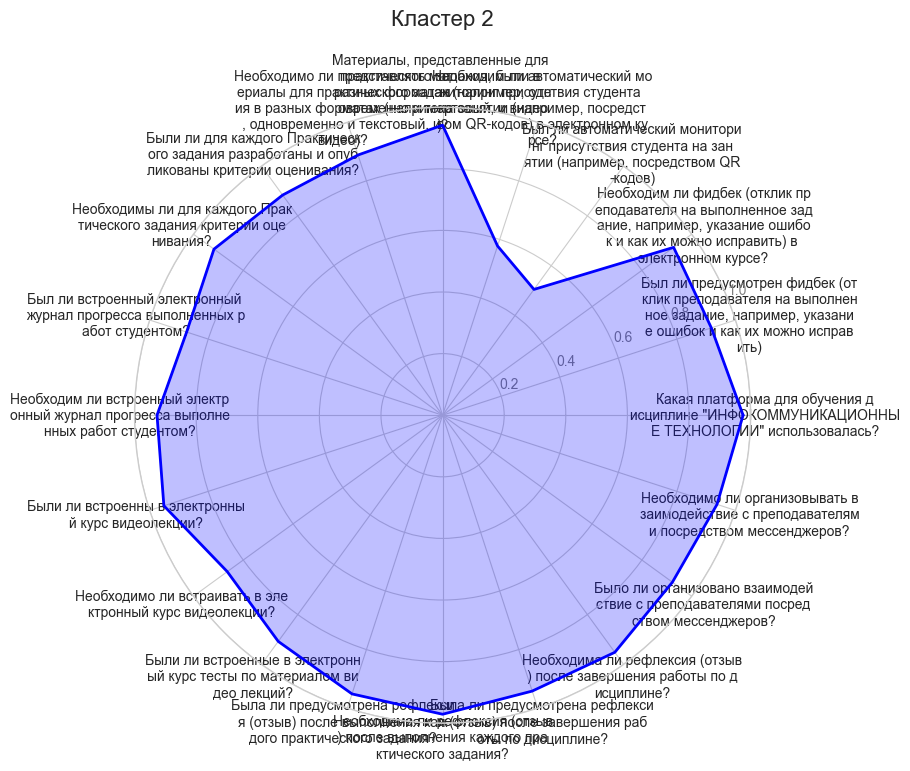

In [25]:
# Функция для добавления переносов строк в длинные метки
def wrap_labels(labels, max_width=30):
    wrapped_labels = []
    for label in labels:
        if len(label) > max_width:
            wrapped_label = '\n'.join([label[i:i + max_width] for i in range(0, len(label), max_width)])
            wrapped_labels.append(wrapped_label)
        else:
            wrapped_labels.append(label)
    return wrapped_labels

# Обновленная функция для создания радиальной диаграммы
def plot_radar_chart(cluster_data, cluster_id, feature_columns):
    # Установим количество признаков
    num_features = len(feature_columns)
    
    # Создадим углы для каждого признака
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]  # Замкнем круг
    
    # Подготовим данные для графика
    values = cluster_data.mean().tolist()
    values += values[:1]  # Замкнем круг
    
    # Добавим переносы строк в метки
    wrapped_labels = wrap_labels(feature_columns)
    
    # Создадим график
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], color="grey", size=10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(wrapped_labels)
    ax.set_title(f'Кластер {cluster_id}', size=16, pad=20)
    plt.show()

# Построение радиальных диаграмм для каждого кластера
for cluster_id in sorted(df_with_clusters['cluster'].unique()):
    cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id][feature_columns]
    plot_radar_chart(cluster_data, cluster_id, feature_columns)
    
    # Установим изначальные названия вопросов в качестве подписей
    original_names = [reverse_mapping[feature] for feature in feature_columns]
    plot_radar_chart(cluster_data, cluster_id, original_names)

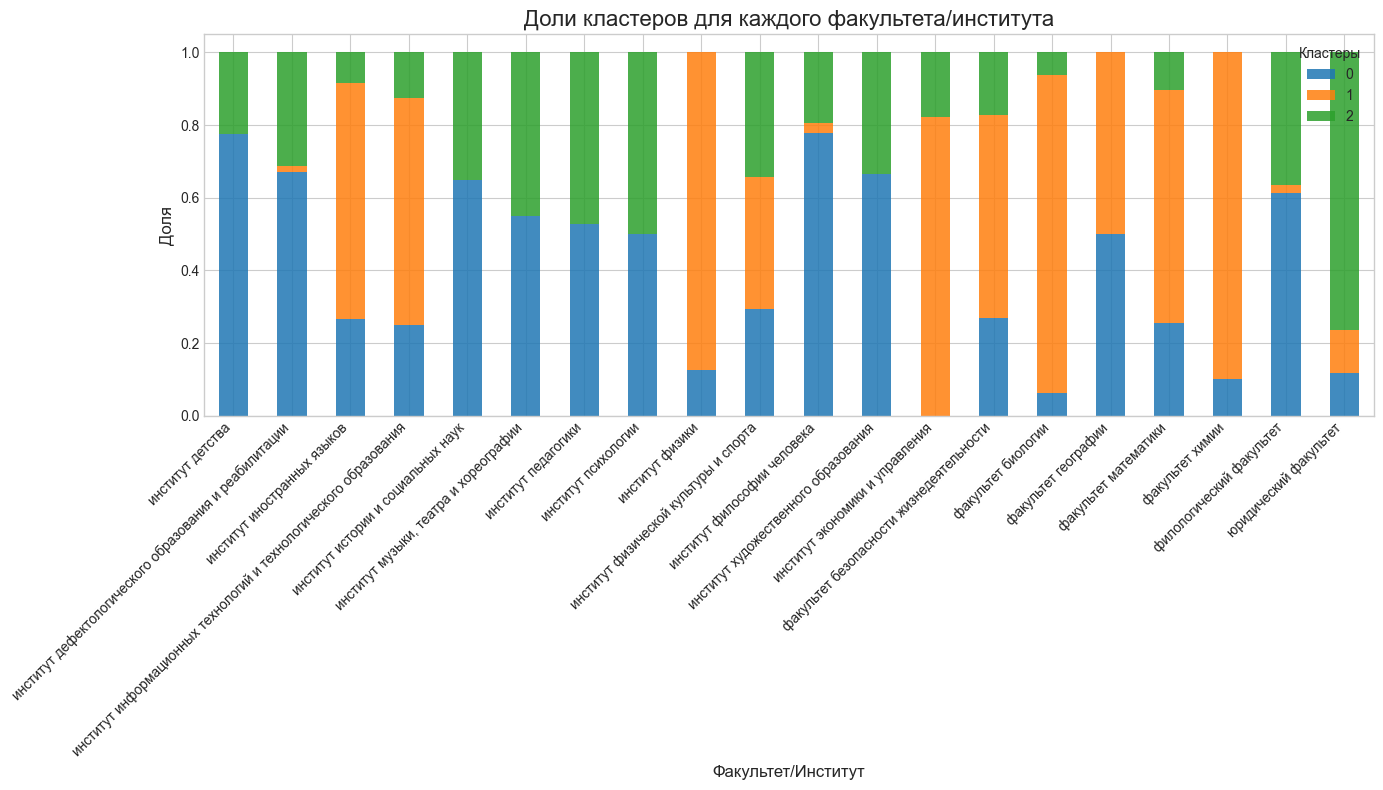

In [26]:
# Построение столбиковой диаграммы с долями кластеров для каждого факультета/института
faculty_cluster_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Цвета для кластеров
    alpha=0.85
)

# Настройка графика
plt.title('Доли кластеров для каждого факультета/института', fontsize=16)
plt.xlabel('Факультет/Институт', fontsize=12)
plt.ylabel('Доля', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Кластеры', fontsize=10)
plt.tight_layout()

# Отображение графика
plt.show()

## 6. Выводы и рекомендации

В данном исследовании мы провели анализ данных опроса студентов о цифровых образовательных технологиях с использованием методов снижения размерности (UMAP) и кластеризации (K-Means и DBSCAN).

### Основные результаты:

1. **Снижение размерности**: Мы успешно применили алгоритм UMAP для снижения размерности бинарных данных, используя метрику Жаккара, которая наиболее подходит для бинарных признаков. Это позволило визуализировать структуру данных в двумерном пространстве. Оптимальные параметры UMAP были определены с помощью силуэтного анализа.

2. **Кластеризация**: Мы выявили оптимальное количество кластеров с помощью метода локтя и силуэтного анализа, а затем применили алгоритмы K-Means и DBSCAN для группировки студентов. Каждый кластер представляет группу студентов с похожими ответами на вопросы опроса.

3. **Характеристики кластеров**: Мы проанализировали характеристики каждого кластера, выявив наиболее важные признаки, отличающие один кластер от других. Это позволило интерпретировать каждый кластер с точки зрения отношения студентов к различным аспектам цифровых образовательных технологий.

4. **Распределение факультетов**: Мы исследовали распределение студентов разных факультетов по кластерам, что позволило оценить, насколько принадлежность к определенному факультету влияет на отношение к цифровым образовательным технологиям.

### Рекомендации:

1. **Персонализация обучения**: На основе выявленных кластеров можно разработать персонализированные подходы к обучению для разных групп студентов, учитывая их отношение к различным цифровым технологиям.

2. **Целевое обучение преподавателей**: Результаты анализа могут быть использованы для разработки программ повышения квалификации преподавателей, направленных на развитие навыков работы с теми цифровыми технологиями, которые вызывают наибольшие затруднения у студентов.

3. **Улучшение цифровой инфраструктуры**: На основе выявленных паттернов можно определить приоритетные направления развития цифровой инфраструктуры университета.

4. **Дальнейшие исследования**: Рекомендуется провести дополнительные исследования для более глубокого понимания выявленных кластеров, например, с использованием качественных методов исследования (интервью, фокус-группы).